# 1. Khai báo thư viện

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import torch.optim as optim

# 2. Nạp dữ liệu 

In [2]:
# Số lượng luồng xử lí nạp dữ liệu
num_workers = 5
# Số lượng sample trong 1 batch
batch_size = 64

# Chuyển data về định dạng torch.FloatTensor
transform = transforms.ToTensor()

# Nạp tập dữ liệu training
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# Load dữ liệu
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)



# 3. Trực quan dữ liệu

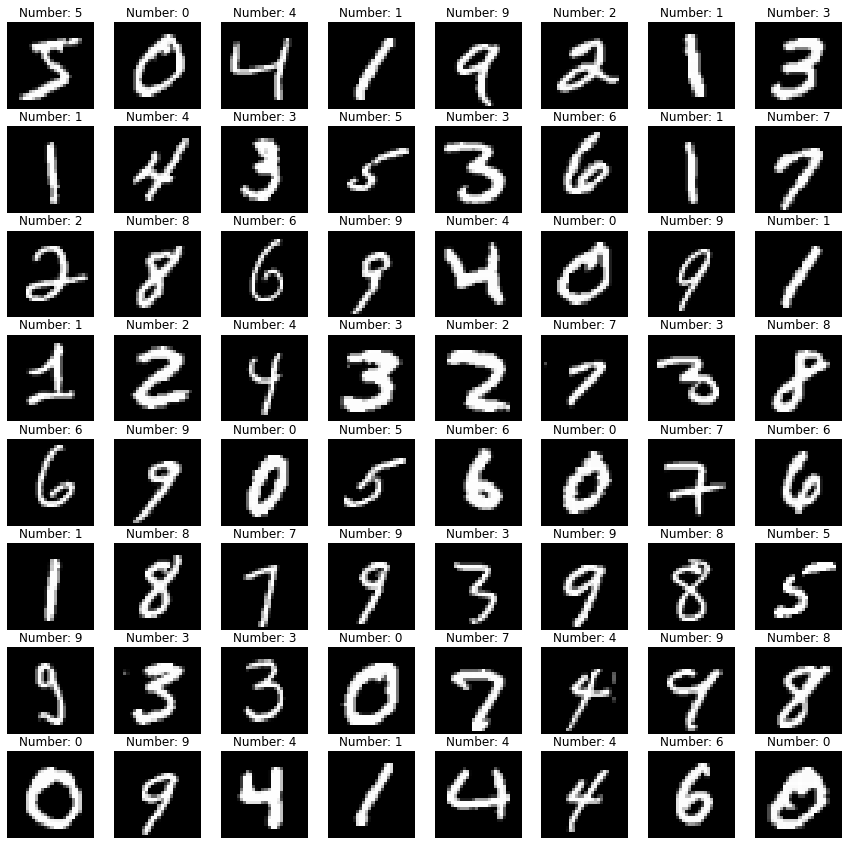

In [3]:
# Lấy ra một batch dữ liệu
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Trực quan hóa tất cả dữ liệu trong 1 batch gồm 64 ảnh
fig = plt.figure(figsize=(15, 15))
# số lượng sample trên hàng và cột được trực quan
columns = 8
rows = 8
for i in range(1, columns*rows+1):
    img = np.squeeze(images[i-1])
    fig.add_subplot(rows, columns, i).set_title(f'Number: {labels[i-1]}')
    plt.axis('off')
    plt.imshow(img,  cmap='gray')
plt.show()    

# 4. Định nghĩa mô hình Discriminator và Generator



In [4]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out


# 6. Xây dựng mạng hoàn chỉnh


In [5]:
# Tham số của 2 mô hình

# learning rate
lr = 0.002
# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32
# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32
# training hyperparams
num_epochs = 100
print_every = 400
sample_size=16


# Khởi tạo tham số
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# 7. Xây dựng hàm loss


In [6]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


# 8. Huấn luyên mô hình

In [7]:
samples = []
losses = []

# Các tham số mô hình
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        # Tính gradient
        d_loss.backward()
        # Cập nhật  gradient
        d_optimizer.step()

        # gọi zero_grad bởi hàm backward tích lũy lại gradient sau mỗi lần gọi
        g_optimizer.zero_grad()

        # 1. Train with fake images and flipped labels

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))


    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

C:\Users\khanh\anaconda3\envs\py\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3766 | g_loss: 0.7544
Epoch [    1/  100] | d_loss: 1.1192 | g_loss: 1.6189
Epoch [    1/  100] | d_loss: 1.0596 | g_loss: 2.1911
Epoch [    2/  100] | d_loss: 1.2672 | g_loss: 2.1205
Epoch [    2/  100] | d_loss: 1.6010 | g_loss: 0.8758
Epoch [    2/  100] | d_loss: 1.3386 | g_loss: 1.0697
Epoch [    3/  100] | d_loss: 1.4391 | g_loss: 1.0591
Epoch [    3/  100] | d_loss: 1.4217 | g_loss: 0.8053
Epoch [    3/  100] | d_loss: 1.3690 | g_loss: 0.6392
Epoch [    4/  100] | d_loss: 1.3468 | g_loss: 0.6954
Epoch [    4/  100] | d_loss: 1.2702 | g_loss: 0.9652
Epoch [    4/  100] | d_loss: 1.1804 | g_loss: 1.9446
Epoch [    5/  100] | d_loss: 1.2514 | g_loss: 0.8019
Epoch [    5/  100] | d_loss: 1.1059 | g_loss: 1.3243
Epoch [    5/  100] | d_loss: 1.0616 | g_loss: 0.9924
Epoch [    6/  100] | d_loss: 1.0865 | g_loss: 1.4306
Epoch [    6/  100] | d_loss: 1.2327 | g_loss: 1.3746
Epoch [    6/  100] | d_loss: 0.4781 | g_loss: 20.1795
Epoch [    7/  100] | d_los

# 9. Training Loss

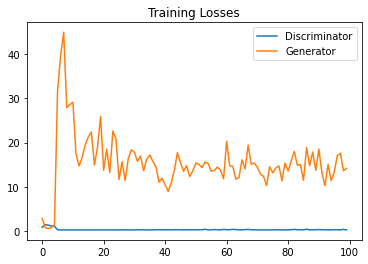

In [8]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()


# 10. Tạo sample từ quá trình huấn luyện


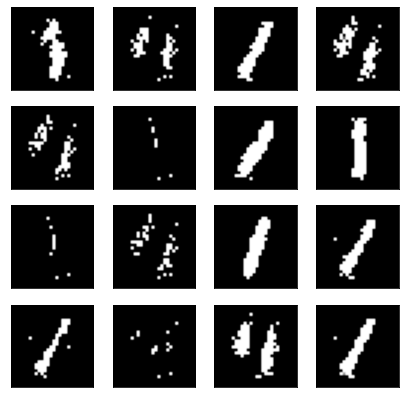

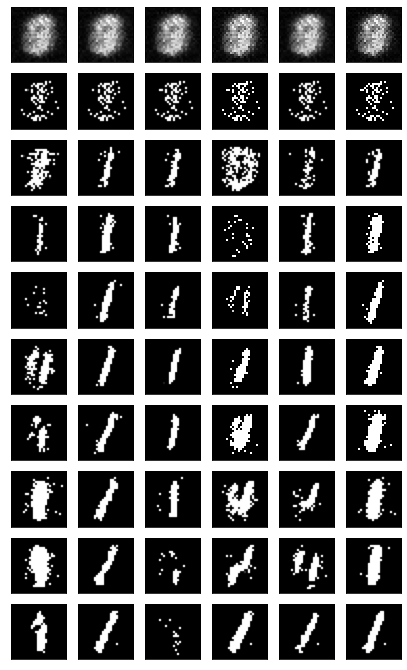

In [9]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples)

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# 11. Sampling from the generator



C:\Users\khanh\anaconda3\envs\py\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


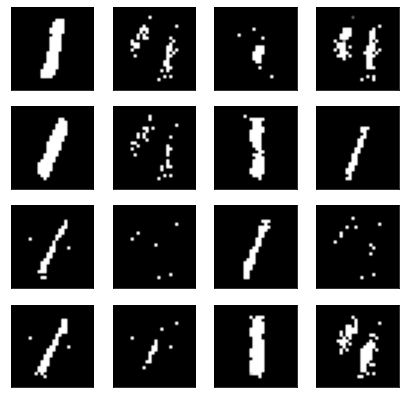

In [10]:

# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])